In [16]:
# Step 0. Load libraries and custom modules
# Basic input/output
import pickle
import urllib
import tarfile
# Matrices and dataframes
import numpy as np
import pandas as pd
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# Data pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
# Clustering
from sklearn.cluster import KMeans
# Metrics
from sklearn.metrics import silhouette_score, adjusted_rand_score

In [2]:
# Step 1. Load data and prepare
# Information: These data contain gene expression values from a 
# manuscript authored by The Cancer Genome Atlas (TCGA) Pan-Cancer 
# analysis project investigators.
# There are 881 samples (rows) representing five distinct cancer 
# subtypes. Each sample has gene expression values for 
# 20,531 genes (columns). The dataset is available from the 
# UC Irvine Machine Learning Repository

# The labels are strings containing abbreviations of cancer types:
# BRCA: Breast invasive carcinoma
# COAD: Colon adenocarcinoma
# KIRC: Kidney renal clear cell carcinoma
# LUAD: Lung adenocarcinoma
# PRAD: Prostate adenocarcinoma

# 1.1 Manual download (About 200MB)
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
# archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"
# # Build the url
# full_download_url = urllib.parse.urljoin(url, archive_name)

# # Download the file
# r = urllib.request.urlretrieve (full_download_url, archive_name)

# # Extract the data from the archive
# tar = tarfile.open(archive_name, "r:gz")
# tar.extractall()
# tar.close()
# 1.2 Assume you have this on a data folder
df_raw_data = pd.read_csv('../Data/Raw/TCGA_data.csv')
df_raw_labels = pd.read_csv('../Data/Raw/TCGA_labels.csv')

In [3]:
# 1.2 Let's get the basic info
df_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20532 entries, Unnamed: 0 to gene_20530
dtypes: float64(20531), object(1)
memory usage: 125.5+ MB


In [4]:
# 1.3 Let's see a sample of the data
df_raw_data.sample(10)

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
500,sample_500,0.0,2.924765,2.654183,6.663558,9.341895,0.0,8.005950,0.000000,0.000000,...,6.620494,9.458999,10.123229,6.212562,10.157713,11.421118,10.844808,10.216006,5.654857,0.000000
756,sample_756,0.0,1.149975,0.462576,5.861427,10.092440,0.0,5.445833,1.045932,0.000000,...,6.494526,9.549727,10.037602,6.636375,9.459339,10.109922,10.442394,9.574616,3.541862,0.000000
691,sample_691,0.0,4.402695,3.968146,6.306423,10.002393,0.0,6.794676,0.000000,0.000000,...,5.080551,8.002269,9.517053,6.383958,9.775423,11.997081,8.908005,9.659543,7.707159,0.642748
186,sample_186,0.0,4.080444,2.168032,6.817969,9.720733,0.0,7.931027,0.000000,0.000000,...,6.037938,9.024209,9.506440,5.838264,9.613099,10.801256,10.564045,8.855610,3.420321,0.000000
718,sample_718,0.0,0.000000,2.249354,6.873001,9.621334,0.0,9.786846,0.701150,0.000000,...,4.984740,7.940642,10.724394,2.045757,8.975857,12.607631,10.701263,8.879467,4.211160,0.000000
689,sample_689,0.0,3.905851,2.956800,5.872117,9.416907,0.0,9.640388,0.000000,0.822608,...,5.796323,7.791814,10.287759,5.485829,9.909592,11.767998,10.391287,9.384091,4.281498,0.000000
274,sample_274,0.0,1.928276,2.447685,6.551608,9.822673,0.0,8.394810,1.620446,0.000000,...,4.476745,7.797486,10.100649,6.171089,9.634969,12.155514,9.845626,8.943051,7.186946,0.602837
606,sample_606,0.0,3.656576,3.333553,6.356896,8.927950,0.0,9.882391,1.118493,0.000000,...,6.319445,8.531128,10.197438,6.312373,9.180817,12.042005,10.868429,9.081390,8.234693,0.000000
463,sample_463,0.0,1.487692,1.646347,6.073165,10.471442,0.0,6.221817,0.000000,0.000000,...,5.750572,8.131188,9.621977,0.000000,9.916102,12.904996,9.509650,9.269304,8.523797,0.000000
48,sample_48,0.0,3.768449,2.736172,6.698538,10.002281,0.0,7.708953,0.768502,0.434775,...,7.128644,10.141775,10.382408,7.328136,9.752237,11.369843,8.097774,9.028680,4.489042,0.000000


In [5]:
# 1.4 Now let's see the labels info
df_raw_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  801 non-null    object
 1   Class       801 non-null    object
dtypes: object(2)
memory usage: 12.6+ KB


In [6]:
# 1.5 Show a sample of the labels
df_raw_labels.sample(6)

,Unnamed: 0,Class
291,sample_291,KIRC
442,sample_442,BRCA
457,sample_457,BRCA
222,sample_222,KIRC
204,sample_204,KIRC
134,sample_134,BRCA


In [7]:
# Step 2. Transform data 
# 2.1 Drop unused columns
df_interim_data = df_raw_data.drop(df_raw_data.columns[0], axis=1)
df_interim_labels = df_raw_labels.drop(df_raw_labels.columns[0], axis=1)
# 2.2 Concatenate dataframes
df_interim = pd.concat([df_interim_data, df_interim_labels], axis=1)

In [8]:
# Step 3. Perform EDA
# 3.1 Describe the data
df_interim.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133


In [9]:
# Step 4. Cluster the data
# 4.1 Separate the data
X = df_interim.drop(['Class'], axis=1)
y = df_interim[['Class']]
no_clusters = y['Class'].nunique()

# 4.2 Create a preprocessing pipeline
preprocessor = Pipeline([
    ('scaler', MinMaxScaler()),
    ('PCA', PCA(n_components=2, random_state=123))
])

# 4.3 Create a clusterer pipeline
clusterer = Pipeline([
    ('kmeans', KMeans(n_clusters=no_clusters, 
                      init='k-means++', 
                      random_state=123))
])

# 4.4 Join the preprocessing and clusterer into a pipe
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('clusterer', clusterer)
])

# 4.5 Fit the data into the pipe
pipe.fit(X)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('PCA',
                                  PCA(n_components=2, random_state=123))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(n_clusters=5, random_state=123))]))])

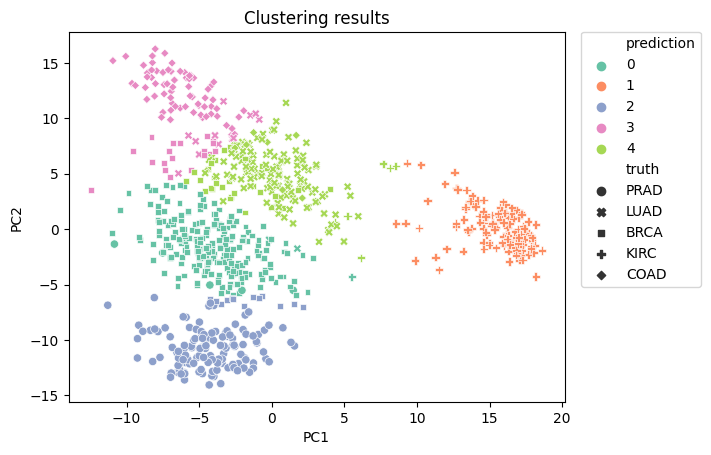

In [15]:
# 4.6 Create a dataframe placeholder
df = pd.DataFrame(pipe['preprocessor'].transform(X), 
                  columns=['PC1','PC2'])
df['prediction'] = pipe['clusterer']['kmeans'].labels_
df['truth'] = y

# 4.7 Compare the results using a plot
plot = sns.scatterplot(x='PC1', 
                       y='PC2', 
                       data=df, 
                       hue='prediction', 
                       style='truth',
                       palette= 'Set2')
plot.set_title('Clustering results')
plt.legend(bbox_to_anchor=(1.02,1.02))
plt.show()

In [ ]:
# 4.8 Calculate Silhouette Score
preproc_data = pipe['preprocessor'].transform(X)
s_score = silhouette_score(preproc_data, df['prediction'])
print(f'The silhouette score is {s_score:.3f}')

In [23]:
# 5. Visualize using TSNE
X_tsne = TSNE(n_components=2, init='random', ).fit_transform(X)

/Users/alexismena/Documents/Data_Projects/Python/Model_Catalog/.Catalog/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


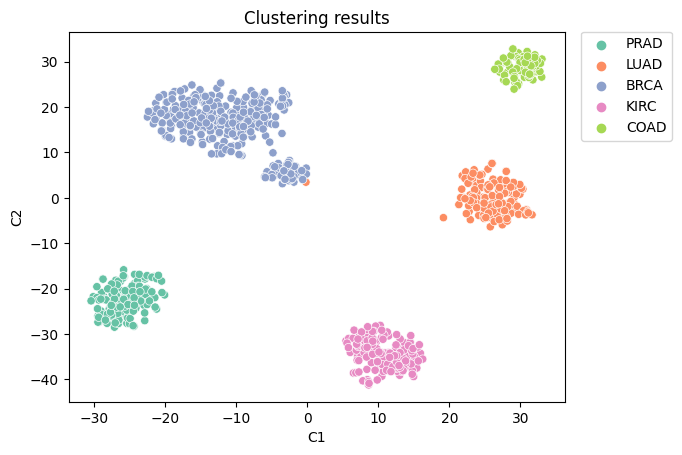

In [22]:
df_tsne = pd.DataFrame(X_tsne, columns=['C1','C2'])
df_tsne['truth'] = y
plot = sns.scatterplot(x='C1', 
                       y='C2', 
                       data=df_tsne,
                       hue='truth',
                       palette= 'Set2')
plot.set_title('Clustering results')
plt.legend(bbox_to_anchor=(1.02,1.02))
plt.show()

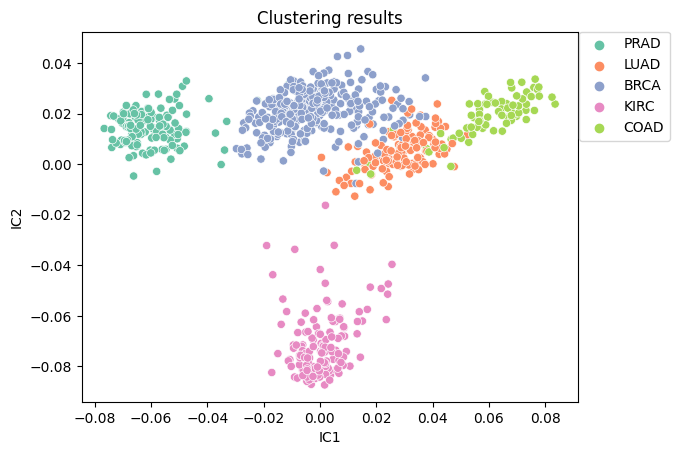

In [31]:
X_fica = FastICA(n_components=2).fit_transform(X)
df_fica = pd.DataFrame(X_fica, columns=['IC1','IC2'])
df_fica['truth'] = y
plot = sns.scatterplot(x='IC1', 
                       y='IC2', 
                       data=df_fica,
                       hue='truth',
                       palette= 'Set2')
plot.set_title('Clustering results')
plt.legend(bbox_to_anchor=(1.2,1.02))
plt.show()

In [ ]:
# Bibliography
# https://realpython.com/k-means-clustering-python/